<a href="https://colab.research.google.com/github/sheramir/MIT-DS/blob/main/Malaria_Detection_Full_Code_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

## <b>Executive Summary</b>

1. In the Milestone I've built and evaluated 5 models:

  * **Base model:** With 3 convolution blocks and 1 dense block, achieved a reasonable level of accuracy, but the training was not stable.
  * **Model-1:** By adding 1 convolutional block and 2 dense layers to the base model, the model showed a slight improvement in accuracy but still exhibited some instability in validation loss.
  * **Model-2:** By adding BatchNormalization and LeakyRelu,  training converged little better but results on the test data wasn't  better than model-1.
  * **Model-3:** Based on Model-2 and adding data augmentation (horizontal flip, rotation, zoom) to increase data diversity and improve generalization,  showed improvements in training stability and accuracy. It achieved the best results so far.
  * **Model-4:** Using transfer learning with VGG16 pre-trained model for feature extraction, showed the worst results on the test set accuracy, especially in detection of parasitized cells.
  * **Model-5:** This is model-2 but training on HSV images. The results are similar to model-2 with RGB.

2. Most important findings from the Milestone:
* The Data: parasitized cells tend to have distinct red/purple spots within the cell. The model needs to learn the features related to the spots (color, shape, size, distribution).
* Transfer learning with VGG16 model doesn't give good results. The blood cells images features are very different from Imagenet features, so using pretrained imagenet weights doesn't give good results compared to a dedicated trained CNN network.
* Bigger network (more Conv blocks and more dense layers) gives better results than base model, though the base model with only 3 Conv layers was already quite reasonable, and better than the VGG model.
* BatchNormalization looks more stable in training but the results on the test set were not always better.
* Adding augmentation to the training helps generalize the data, stabilize the training and give better results.
* Training with HSV images gives similar results to RGB. However, adding augmentation to HSV images would be more complex and involve generating augmentation on RGB data before converting to HSV.

3. Proposed model:
* The proposed model includes
  - 4 Convolution blocks (#filters = 32, 64, 128, 128) with maxpool
  - 3 Dense layers (sizes 256, 128, 64)
  - 1 binary output (sigmoid activation function)
  - LeakyRelu activation on all other layers
* In this notebook I will continue to explore the need of BatchNormalization with augmentation, check different classification layers size and explore how to minimize False Negatives which is more critical in malaria detection than False Positives.

## **Next Steps:**
In this notebook I will continue to explore different models and compare the results. Some models are the same as milestone and are re-trained for comparisons.</br>

Summary and recommendations are provided at the end of this notebook.</br>


The models I test in this notebook:</br>
* **Model-1:** The same model-1 of Milestone.
* **Model-2:** The same model-2 of Milestone (with BatchNormalization).
* **Model-3:** Same as Model-1, but will be trained with augmentation.
* **Model-4:** Same Model-2, but will be trained with augmentation (same as model-3 in Milestone).
* **Model-5:** Similar to Model-2 but with larger dense layers. Each dense layer has double nuerons compared to Model-2. This model also will be trained with augmentation.

####**Questions I explore in this notebook**:
- What is the best model to adopt?
- Does BatchNormalization improve the results?
- Does augmentation imporve the results?
- Is doubling the size of the classification dense layer improve the results?
- Can we improve False-Negative results to imporve the detection (in trade-off of False-Positive which is less critical in malaria detection).
  

###<b> Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [2]:
# Importing libraries for files and images processing
# Libraries for Neural-Networks will be imported later

import numpy as np

# Files handling libraries
import os
from zipfile import ZipFile

from tqdm import tqdm

# Images handling library
import cv2

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize random seed
import random
np.random.seed(42)
random.seed(42)

### <b>Let us load the data</b>

**Extract the files from the Zip:**

In [3]:
# The zip file is in a permanent Google drive
# The files are extracted and put in a temporary drive in each session

zip_file_path = '/content/drive/MyDrive/ADSP/Malaria Detection/cell_images.zip'
data_path = '/content/cell_images'

# Check if data was already extracted from zip file
if not os.path.exists(data_path):
  # Open the zip file
  with ZipFile(zip_file_path, 'r') as zip:
    zip.extractall()
    print('Data was extracted to', data_path)
else:
  print('Data was already extracted to', data_path)

Data was extracted to /content/cell_images


**Extract the data from the folders into numpy arrays:**

In [4]:
# Function that loads the images from either 'train' or 'test' folders
# and returns numpy arrays of X and y
def load_dataset(folder_path, group='test', img_size = 64):
    X = []
    y = []
    categories = ['parasitized', 'uninfected']

    for category in categories:
        path = os.path.join(folder_path, group, category)
        print (f'Reading images from {path}')
        for img in tqdm(os.listdir(path)):

            # Read the image files
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

            # Resize the image to uniform size
            img_array = cv2.resize(img_array, (img_size, img_size))

            # Convert to RGB (cv2 use BGR by default)
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

            # Add image to list
            X.append(img_array)

            # Create binary labels
            y.append(0 if category == 'uninfected' else 1)

    return np.array(X), np.array(y) # return as numpy arrays


In [5]:
X_train, y_train = load_dataset(data_path, group='train')
X_test, y_test = load_dataset(data_path, group='test')

Reading images from /content/cell_images/train/parasitized


100%|██████████| 12582/12582 [00:13<00:00, 965.04it/s] 


Reading images from /content/cell_images/train/uninfected


100%|██████████| 12376/12376 [00:09<00:00, 1349.45it/s]


Reading images from /content/cell_images/test/parasitized


100%|██████████| 1300/1300 [00:01<00:00, 1265.69it/s]


Reading images from /content/cell_images/test/uninfected


100%|██████████| 1300/1300 [00:00<00:00, 1472.05it/s]


###<b> Check the shape of train and test images

In [6]:
print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)

Shape of X_train:  (24958, 64, 64, 3)
Shape of X_test:  (2600, 64, 64, 3)


###<b> Check the shape of train and test labels

In [7]:
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of y_train:  (24958,)
Shape of y_test:  (2600,)


### <b>Check the minimum and maximum range of pixel values for train and test images

In [8]:
print('X_train pixels range: ', X_train.min(),'-' , X_train.max())
print('X_test pixels range: ', X_test.min(),'-' , X_test.max())


X_train pixels range:  0 - 255
X_test pixels range:  0 - 255


###<b>Normalize the images

In [9]:
if X_train.max() > 1:   # Don't normalize more than once
  X_train = (X_train/255).astype('float32') # need to convert to float32 for later cv2 conversions
if X_test.max() > 1:
  X_test = (X_test/255).astype('float32')

print('X_train pixels range: ', X_train.min(),'-' , X_train.max())
print('X_test pixels range: ', X_test.min(),'-' , X_test.max())

X_train pixels range:  0.0 - 1.0
X_test pixels range:  0.0 - 1.0


###<b> Count the number of values in both uninfected and parasitized

In [10]:
labels_train, counts_train = np.unique(y_train, return_counts=True)
print('Train set - Number of uninfected images: ', counts_train[0])
print('Train set - Number of parasitized images: ', counts_train[1])

labels_test, counts_test = np.unique(y_test, return_counts=True)
print('Test set - Number of uninfected images: ', counts_test[0])
print('Test set - Number of parasitized images: ', counts_test[1])

Train set - Number of uninfected images:  12376
Train set - Number of parasitized images:  12582
Test set - Number of uninfected images:  1300
Test set - Number of parasitized images:  1300


### <b>Data Exploration</b>
Let's visualize the images from the train data

In [11]:
# A function that plots a grid of images

np.random.seed(42)

def plot_images_grid(X, y, row=4, col=4, figsize=(8,8), randomize=True, balance=True):
  """Plots a grid of images selected from X with corresponding labels from y.

  Args:
    X: A NumPy array of images.
    y: A NumPy array of labels corresponding to the images in X.
    row: The number of rows in the image grid. Defaults to 4.
    col: The number of columns in the image grid. Defaults to 4.
    figsize: The size of the figure to be plotted. Defaults to (8, 8).
    randomize: A boolean indicating whether to randomize the selection of images.
               Defaults to True.
    balance: A boolean indicating whether to balance the number of images
             from each class. Defaults to True.
  """
  total_images = min(row * col,len(X))
  half = int(total_images/2)
  X_plot = []
  y_plot = []

  # Extract images from X,y and put in X_plot,y_plot
  for i in range(len(X)):

    # Set index to be random or incremental
    if randomize:
      indx = np.random.randint(0, len(X)) # Get random images
    else:
      indx = i  # Get incremental images

    # Add uninfected cell image
    if y[indx] == 0:
      if (balance and y_plot.count('uninfected') < half) or not balance:
        X_plot.append(X[indx])
        y_plot.append('uninfected')

    # Add parasitized cell image
    if y[indx] == 1:
      if (balance and y_plot.count('parasitized') < (total_images - half)) or not balance:
        X_plot.append(X[indx])
        y_plot.append('parasitized')

    # Exit loop if enough images in X_plot
    if len(X_plot) == total_images:
      break

  plt.figure(figsize=figsize)
  for i in range(total_images):
    plt.subplot(row, col, i+1)
    plt.imshow(X_plot[i])
    plt.title(y_plot[i])
    plt.axis('off')
  plt.show()

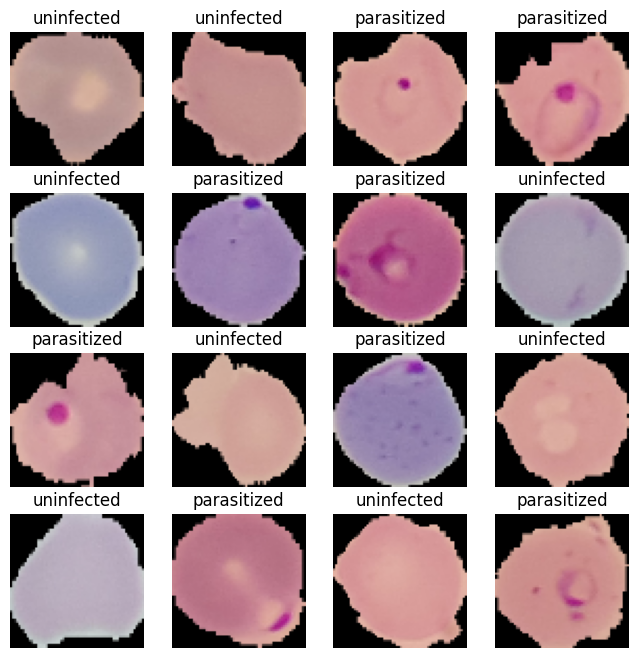

In [12]:
plot_images_grid(X_train, y_train, 4, 4)

####<b> Observations and insights:</b>
- Parasited cells appear to have distinct spots.
- The color of the cells is ranging between red, orange, blue, purple. The color however is not indicating of parasited cells.


## **Model Building**

###<b> Importing the required libraries for building and training our Model

In [13]:
import numpy as np

# Deep Learning libraries
import tensorflow as tf

import keras


# Importing all the different layers and optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Clearing backend
from tensorflow.keras import backend

# prediction test reports
from sklearn.metrics import classification_report, confusion_matrix

# Splitting data to train and val
from sklearn.model_selection import train_test_split

# Images augmentation generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

tf.random.set_seed(42)



###<b> Definitions of some useful functions

In [14]:
# Clearing backend and random seeds

def clear_session():
  backend.clear_session()
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)

In [15]:
# Function to calculate loss and accuracy on test dataset

def model_evaluate(model, xtest, ytest):
    test_loss, test_acc = model.evaluate(xtest, ytest)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    return test_loss, test_acc

In [16]:
# Create a dictionary to store model results for comparison

model_results = {
    'Model': [],
    'val_acc': [],
    'val_loss': [],
    'test_acc': [],
    'test_loss': []
}

In [17]:
# Function that stores the model results in model_results dictionary

def store_model_results(model_name, history, test_acc, test_loss):
  # Add model name
  model_results['Model'].append(model_name)

  # Add test accuracy and loss
  model_results['test_acc'].append(round(test_acc,4))
  model_results['test_loss'].append(round(test_loss,4))

  # Get best epoch from history (best val_loss)
  best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
  best_val_loss = history.history['val_loss'][best_epoch]
  best_val_accuracy = history.history['val_accuracy'][best_epoch]

  # Add validation accuracy and loss
  model_results['val_acc'].append(round(best_val_accuracy,4))
  model_results['val_loss'].append(round(best_val_loss,4))

In [18]:
# Function to print classification report and confusion matrix

def print_report(ytest,ypred):

  # Printing the classification report
  print(classification_report(ytest, ypred))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(ytest, ypred)

  plt.figure(figsize = (8, 5))

  sns.heatmap(cm, annot = True,  fmt = '.0f')

  plt.ylabel('Actual')

  plt.xlabel('Predicted')

  # Display the plot
  plt.show()

In [19]:
# Explore the errors

def get_errors(xtest, ytest, ypred):

  X_errors = xtest[ypred.flatten() != ytest]
  y_errors = ytest[ypred.flatten() != ytest]

  return X_errors, y_errors

#print('Number of errors:', X_test_errors.shape[0])

#plot_images_grid(X_errors, y_errors, 10, 5, figsize=(8, 16), randomize=False, balance=False)

In [20]:
# Function to plot model accuracy/loss curves and print test accuracy.

def plot_accuracy_loss(history):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


###<b> Model 1



In [21]:
clear_session()

###<b> Building the Model

In [22]:
# Building CNN model1:
# The model has 4 convolution layers with Relu activation
# A maxpool layer after each Conv layer
# 3 hidden fully-connected layers
# and one output layer with sigmoid activation (binary).

def cnn_model1():

  model = Sequential()
  model.add(Input(shape=(64, 64, 3)))

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 4rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten and Fully Connected Layers
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.4)) # Helps prevent overfitting

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3)) # Helps prevent overfitting

  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2)) # Helps prevent overfitting

  # Sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

model1 = cnn_model1()

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,593 (3.08 MB)

 Trainable params: 806,593 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [23]:
model1.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> Using Callbacks</b>

Instead of early stopping I decided to train on all epochs and get the best checkpoint on val_loss. I want to make sure that the training doesn't stop too soon and I want to see the loss graph of all the training session.

In [24]:
# Use callbacks to store best weights after training all epochs
model_weights_file = 'model1.mdl_wts.keras'
callbacks = [ModelCheckpoint(model_weights_file, monitor = 'val_loss', save_best_only = True)]

#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
#            ModelCheckpoint('.mdl_wts.keras', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [25]:
history1 = model1.fit(X_train, y_train,
                      batch_size = 32, callbacks = callbacks,
                      validation_split = 0.2,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6326 - loss: 0.6490 - val_accuracy: 0.9796 - val_loss: 0.0951
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9714 - loss: 0.0904 - val_accuracy: 0.9667 - val_loss: 0.0624
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9752 - loss: 0.0723 - val_accuracy: 0.9726 - val_loss: 0.0606
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9787 - loss: 0.0621 - val_accuracy: 0.9786 - val_loss: 0.0476
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9807 - loss: 0.0548 - val_accuracy: 0.9627 - val_loss: 0.0729
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9824 - loss: 0.0571 - val_accuracy: 0.9683 - val_loss: 0.0638
Epoch 7/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9824 - loss: 0.0523 - val_accuracy: 0.9808 - val_loss: 0.0493
Epoch 8/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9833 - loss: 0.0501 - val_accuracy: 

###<b> Evaluating the model

In [26]:
# restore best weights
model1.load_weights(model_weights_file)

In [27]:
test_loss,test_acc = model_evaluate(model1, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9905 - loss: 0.0338
Test Accuracy: 0.9858
Test Loss: 0.0424


In [28]:
# Store results in model_results

store_model_results('model1', history1, test_acc, test_loss)

<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



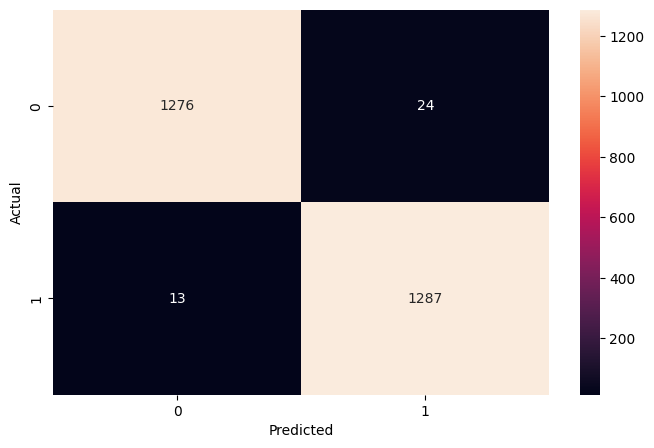

In [29]:
# Predict results on X_test
y_pred = model1.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

<b> Plotting the train and the validation curves

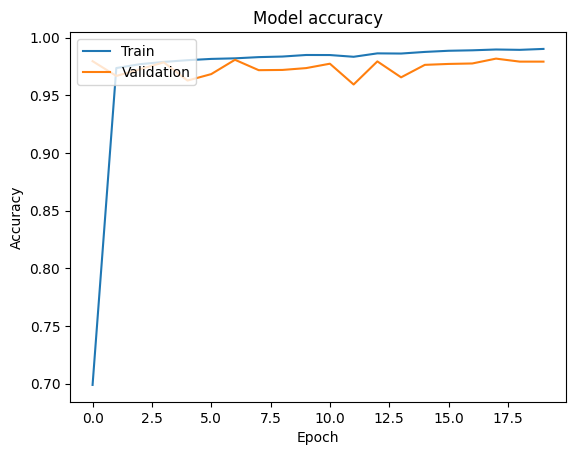

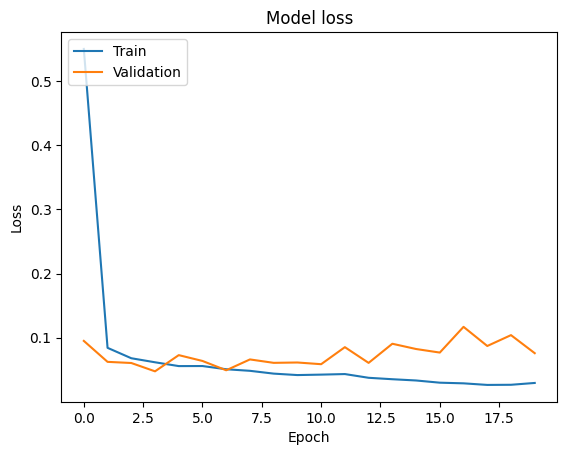

In [30]:
plot_accuracy_loss(history1)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [31]:
clear_session()

###<b> Building the Model

In [32]:
# Building CNN model2:
# Changeing activiation to LeakeyRelu
# Adding BatchNormalization to Conv layers
# (BatchNorm in Dense layers gave worst results so not adding there)

def cnn_model2():

  model = Sequential()
  model.add(Input(shape=(64, 64, 3)))

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 4rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten and Fully Connected Layers
  model.add(Flatten())

  model.add(Dense(256))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.4)) # Helps prevent overfitting

  model.add(Dense(128))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.3)) # Helps prevent overfitting

  model.add(Dense(64))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2)) # Helps prevent overfitting

  # Sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

model2 = cnn_model2()

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 808,001 (3.08 MB)

 Trainable params: 807,297 (3.08 MB)

 Non-trainable params: 704 (2.75 KB)

###<b>Compiling the model

In [33]:
model2.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> Using callbacks

In [34]:
# Using custom callbacks:
# Store weights of best val_loss epoch but only if the training accuracy is not too low.
# This prevents saving weights of first epoch when val_loss happens to be minimum
# but the model is not trained yet.

class ConditionalWeightSavingCallback(tf.keras.callbacks.Callback):
    def __init__(self, min_accuracy=0.95, filepath='best_model.h5'):
        super(ConditionalWeightSavingCallback, self).__init__()
        self.min_accuracy = min_accuracy
        self.filepath = filepath
        self.best_val_loss = float('inf')  # Initialize with infinity

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        accuracy = logs.get('accuracy')

        if accuracy >= self.min_accuracy and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.model.save_weights(self.filepath, overwrite=True)
            print(f"\nSaving weights with val_loss: {val_loss:.4f} and accuracy: {accuracy:.4f}")

weights_file = 'model2.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]

<b>Fit and train the model

In [35]:
history2 = model2.fit(X_train, y_train,
                      batch_size = 32,
                      callbacks = callbacks,
                      validation_split = 0.2,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7813 - loss: 0.4672 - val_accuracy: 0.9810 - val_loss: 0.0403
Epoch 2/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9765 - loss: 0.0763
Saving weights with val_loss: 0.0243 and accuracy: 0.9787
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9765 - loss: 0.0762 - val_accuracy: 0.9876 - val_loss: 0.0243
Epoch 3/20
618/624 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9770 - loss: 0.0663
Saving weights with val_loss: 0.0200 and accuracy: 0.9788
624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9771 - loss: 0.0662 - val_accuracy: 0.9898 - val_loss: 0.0200
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9812 - loss: 0.0597 - val_accuracy: 0.9866 - val_loss: 0.0296
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9811 - loss: 0.0575 - val_accuracy: 0.9858 - val_loss: 0.0311
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9805 - loss: 0.0572 - v

<b>Plotting the train and validation accuracy

In [36]:
# load best weights
model2.load_weights(weights_file)

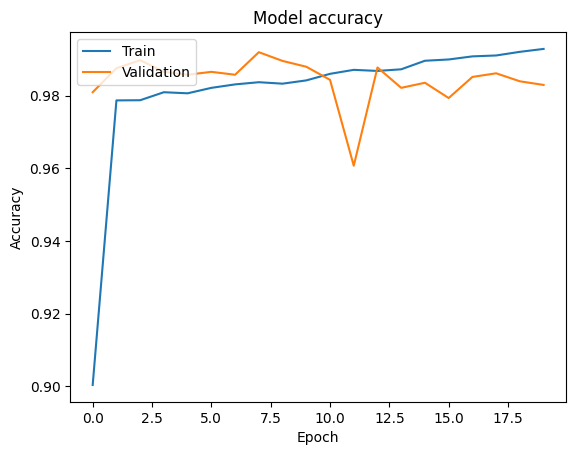

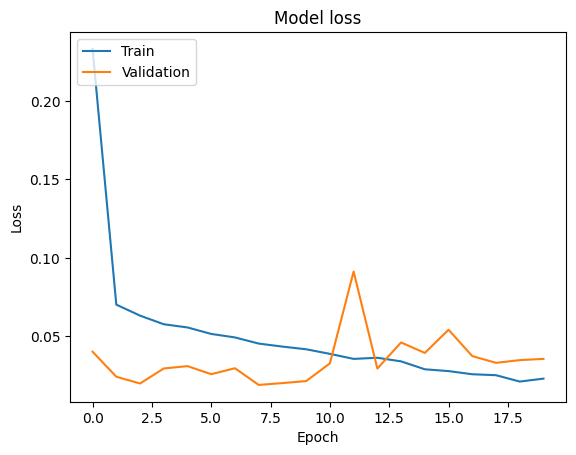

In [37]:
plot_accuracy_loss(history2)


###<b>Evaluating the model

In [38]:
test_loss,test_acc = model_evaluate(model2, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9803 - loss: 0.0871
Test Accuracy: 0.9831
Test Loss: 0.0710


In [39]:
# Store results in model_results

store_model_results('model2', history2, test_acc, test_loss)

<b> Generate the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



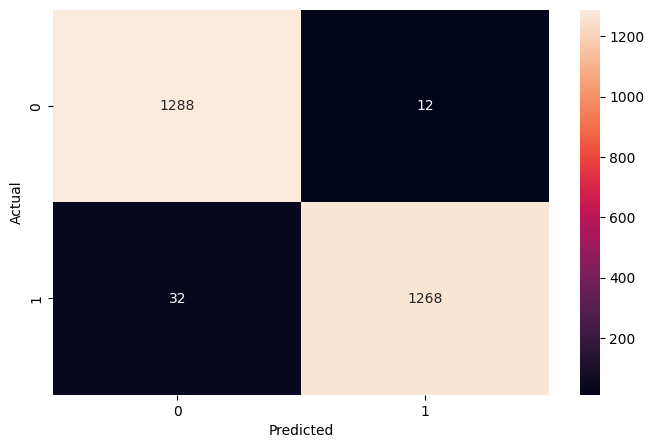

In [40]:
y_pred = model2.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # Convert probabilities to binary

# Print test classification report and
print_report(y_test, y_pred)

####<b>Observations and insights:</b>
* The val_loss during training of model-1 oscilated around 0.1-0.07 and wasn't converging.

* Model-2 added BatchNormalization and LeakyRelu to stabilize the training.

* The training of model-2 converges better and get lower val_loss than model-1, though the results on the test set don't show improvement.

###<b>Model 3 with Data Augmentation
#### <b>This time I will use augmentation on Model-1 and Model-2 to compare models
#### <b>Model 3 is based on Model-1

In [41]:
clear_session()

###<b> Use image data generator

In [42]:
# Seperate samples for train and val image generators
X_aug_train, X_aug_val, y_aug_train, y_aug_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.2,
                                                                  random_state = 42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, # do horizontal flip
                                  zoom_range = [0.9, 1.2], # zoom between 0.9 - 1.2
                                  rotation_range = 30,     # rotate image
                                  fill_mode='constant')    # Keep the background black

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_aug_train , y = y_aug_train,
                                     batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_aug_val, y = y_aug_val,
                                  batch_size = 64, seed = 42, shuffle = True)

####<B>Visualizing Augmented images

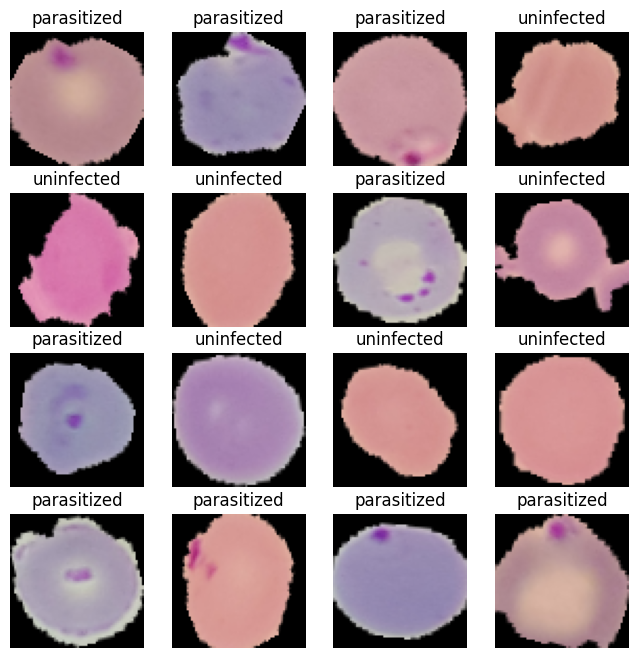

In [43]:
# Creating an iterable for images and labels from the training data
aug_images, aug_labels = next(train_generator)

plot_images_grid(aug_images, aug_labels, 4, 4, figsize=(8, 8), randomize=False, balance=False)

####<b>Observations and insights: </b>
Using augmentation we can add more data samples and generalize the training. It is mostly helpful when the data is too small or too homogeneous.

For augmentation I used horizontal flip, rotation, and zooming. I filled the background with constant black to maintain the shape of the blood cells.

When zooming we need to be carefull not to zoom in/out too much because we can lose the infection spots details in the zoom.

###<b>Building the Model
#### Model 1 + augmentation

In [44]:
# Using model 1 with augmentation

model3 = cnn_model1()  # No BatchNorm

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,593 (3.08 MB)

 Trainable params: 806,593 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Compile the model
model3.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b>Using Callbacks

In [46]:
# Callbacks to save best weights by min val_loss but only if training accuracy is 0.95 or better

weights_file = 'model3.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]

<b> Fit and Train the model

In [47]:
history3 = model3.fit(train_generator,
                      batch_size = 64,
                      callbacks = callbacks,
                      validation_data = val_generator,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.6445 - loss: 0.5689 - val_accuracy: 0.9760 - val_loss: 0.0762
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9774 - loss: 0.0779
Saving weights with val_loss: 0.0635 and accuracy: 0.9767
312/312 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9774 - loss: 0.0779 - val_accuracy: 0.9772 - val_loss: 0.0635
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9795 - loss: 0.0677
Saving weights with val_loss: 0.0511 and accuracy: 0.9782
312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.9795 - loss: 0.0677 - val_accuracy: 0.9826 - val_loss: 0.0511
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9804 - loss: 0.0630 - val_accuracy: 0.9770 - val_loss: 0.0592
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9792 - loss: 0.0584 - val_accuracy: 0.9800 - val_loss: 0.0532
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.9811 - loss: 0.0577 - val

###<B>Evaluating the model

In [48]:
# Load weights from best epoch
model3.load_weights(weights_file)

In [49]:
test_loss,test_acc = model_evaluate(model3, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9918 - loss: 0.0236
Test Accuracy: 0.9869
Test Loss: 0.0338


In [50]:
# Store results in model_results

store_model_results('model3', history3, test_acc, test_loss)

<b>Plot the train and validation accuracy

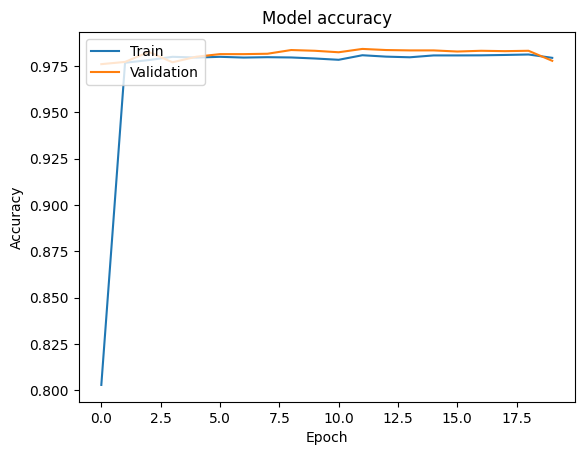

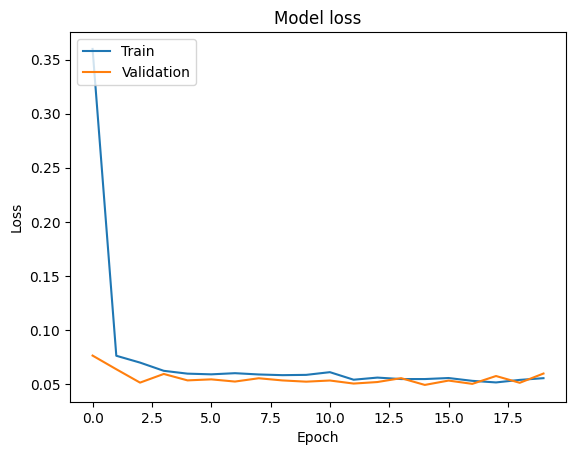

In [51]:
plot_accuracy_loss(history3)

<B>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



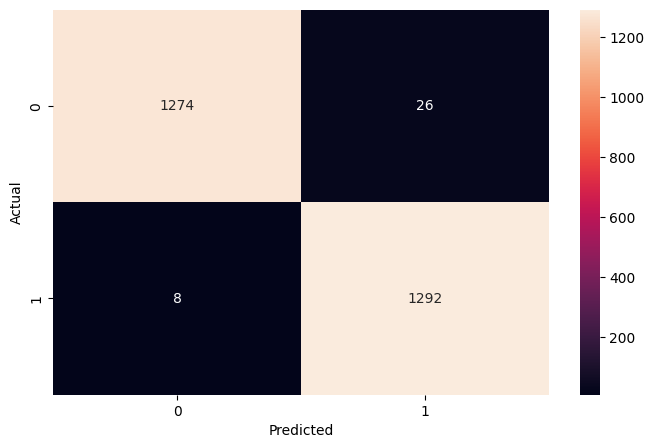

In [52]:
y_pred = model3.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

###<b>Model 4 with Data Augmentation
#### Model 4 is based on Model-2 with augmentation

In [53]:
clear_session()

In [54]:
# Using model 2 with augmentation

model4 = cnn_model2() # With BatchNorm

model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 808,001 (3.08 MB)

 Trainable params: 807,297 (3.08 MB)

 Non-trainable params: 704 (2.75 KB)

###<b>Compiling the model

In [55]:
# Compile the model
model4.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

<b> using callbacks

In [56]:
# Store weights of best val_loss epoch

weights_file = 'model4.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]

#weights_file = 'model4.mdl_wts.keras'
#callbacks = [ModelCheckpoint(weights_file, monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [57]:
# Training using original data withour augmentation
history4 = model4.fit(train_generator,
                      batch_size = 64,
                      callbacks = callbacks,
                      validation_data = val_generator,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - accuracy: 0.7642 - loss: 0.4751 - val_accuracy: 0.8245 - val_loss: 0.4876
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9753 - loss: 0.0799
Saving weights with val_loss: 0.1013 and accuracy: 0.9758
312/312 ━━━━━━━━━━━━━━━━━━━━ 22s 70ms/step - accuracy: 0.9753 - loss: 0.0799 - val_accuracy: 0.9688 - val_loss: 0.1013
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9775 - loss: 0.0733
Saving weights with val_loss: 0.0904 and accuracy: 0.9769
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9775 - loss: 0.0733 - val_accuracy: 0.9748 - val_loss: 0.0904
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9739 - loss: 0.0697
Saving weights with val_loss: 0.0575 and accuracy: 0.9765
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9740 - loss: 0.0697 - val_accuracy: 0.9806 - val_loss: 0.0575
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9796 - los

<b>Plot the train and validation accuracy

In [58]:
model4.load_weights(weights_file)

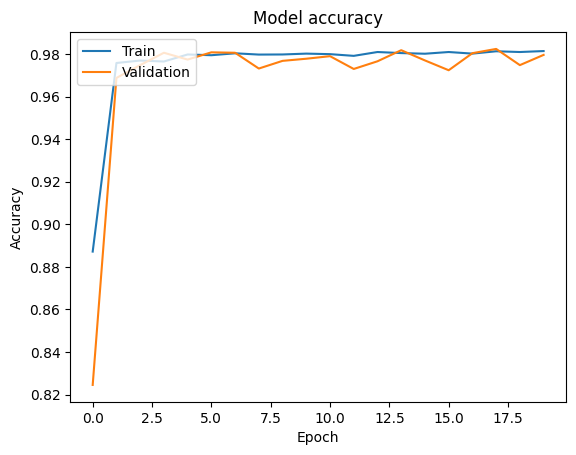

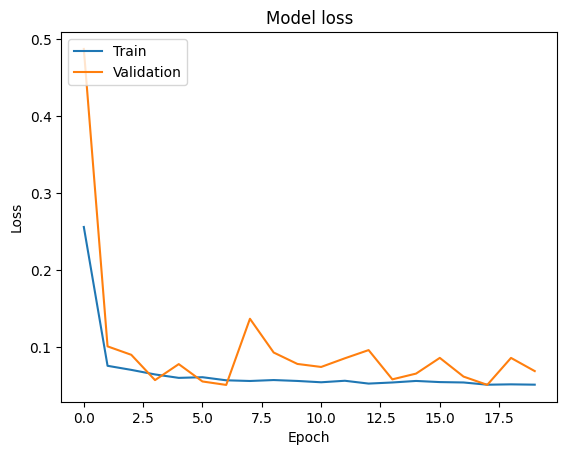

In [59]:
plot_accuracy_loss(history4)

###<b>Observations and insights: </b>

* I used convolution block 3 from VGG. Higher blocks add more complex features (parts of objects such as eyes, wheels etc.) and in our problem and image set these features are not necessary and not helpful.

* Using VGG model doesn't converge well.

###<b> Evaluating the model

In [60]:
test_loss,test_acc = model_evaluate(model4, X_test, y_test)


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9930 - loss: 0.0252
Test Accuracy: 0.9842
Test Loss: 0.0479


In [61]:
# Store results in model_results

store_model_results('model4', history4, test_acc, test_loss)

<b>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1300
           1       0.97      1.00      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



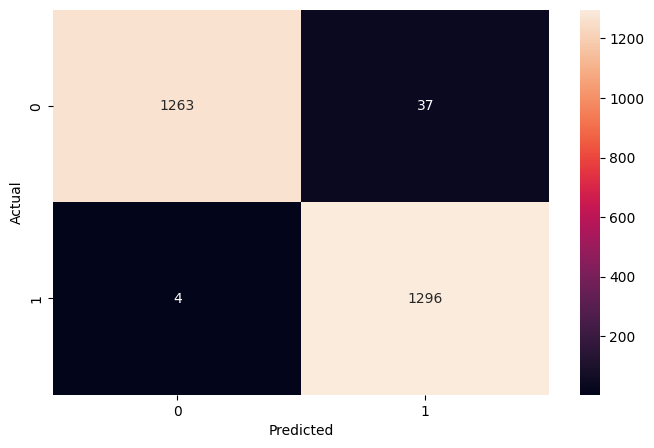

In [62]:
y_pred = model4.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


##<b>Model 5 with Bigger Dense Layer
#### Model 5 is based on Model-2 with bigger classification layers


In [63]:
clear_session()

### **Building the model**

In [64]:
# Building CNN model3:
# Larger Dense layer

def cnn_model3():

  model = Sequential()
  model.add(Input(shape=(64, 64, 3)))

  # 1st Convolutional Layer
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 2nd Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 3rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # 4rd Convolutional Layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size=(2,2)))

  # Flatten and Fully Connected Layers
  model.add(Flatten())

  model.add(Dense(512))    # Enlarge layer to 512 from 256
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.4))  # Helps prevent overfitting

  model.add(Dense(256))    # Enlarge layer to 256 from 128
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.3)) # Helps prevent overfitting

  model.add(Dense(128))    # Enlarge layer to 128 from 64
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2)) # Helps prevent overfitting

  # Sigmoid for binary classification
  model.add(Dense(1, activation='sigmoid'))

  return model

model5 = cnn_model3()

model5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,455,681 (5.55 MB)

 Trainable params: 1,454,977 (5.55 MB)

 Non-trainable params: 704 (2.75 KB)

### **Compile and train the model**

In [65]:
# Compile the model
model5.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

In [66]:
# Callbacks to save best weights by min val_loss but only if training accuracy is 0.95 or better

weights_file = 'model5.weights.h5'
callbacks = [ConditionalWeightSavingCallback(min_accuracy=0.95, filepath=weights_file)]


In [67]:
# Fit and train the model
history5 = model5.fit(train_generator,
                      batch_size = 64,
                      callbacks = callbacks,
                      validation_data = val_generator,
                      shuffle = True,
                      epochs = 20)

Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 35s 88ms/step - accuracy: 0.7362 - loss: 0.5690 - val_accuracy: 0.7859 - val_loss: 0.7625
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9744 - loss: 0.0790
Saving weights with val_loss: 0.0617 and accuracy: 0.9751
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9744 - loss: 0.0790 - val_accuracy: 0.9788 - val_loss: 0.0617
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9746 - loss: 0.0761 - val_accuracy: 0.9822 - val_loss: 0.0625
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9779 - loss: 0.0642 - val_accuracy: 0.9758 - val_loss: 0.0956
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9784 - loss: 0.0653 - val_accuracy: 0.9790 - val_loss: 0.0757
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - accuracy: 0.9784 - loss: 0.0613 - val_accuracy: 0.9810 - val_loss: 0.0795
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.9789 - loss: 0.061

###<B>Evaluating the model

In [68]:
# Load weights from best epoch
model5.load_weights(weights_file)

In [69]:
# Evaluate test set
test_loss,test_acc = model_evaluate(model5, X_test, y_test)

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9902 - loss: 0.0310
Test Accuracy: 0.9881
Test Loss: 0.0358


In [70]:
# Store results in model_results

store_model_results('model5', history5, test_acc, test_loss)

### **Plot reports**

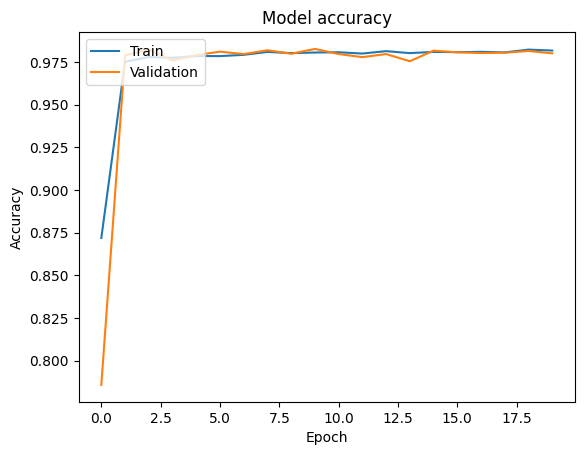

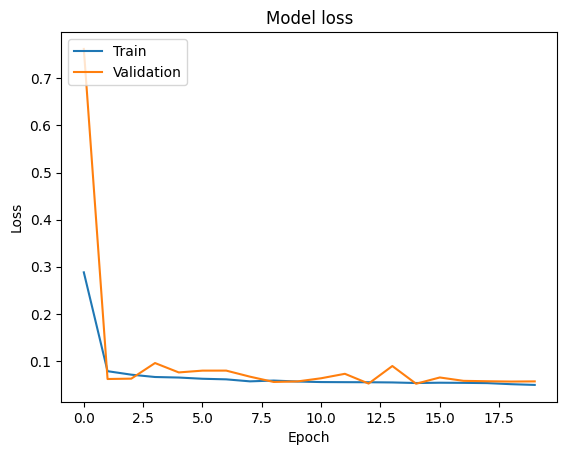

In [71]:
plot_accuracy_loss(history5)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1300
           1       0.99      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



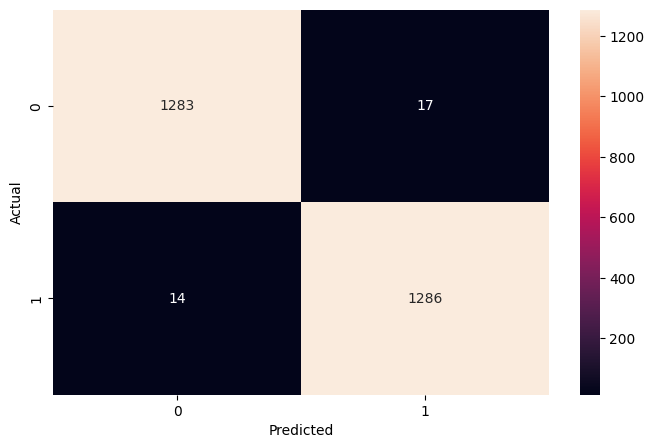

In [72]:
y_pred = model5.predict(X_test)
y_pred = (y_pred > 0.5).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

# **Summary Results Comparison of All Models:**

In [73]:
# Summary of model results:

import pandas as pd

pd.DataFrame(model_results).T

,0,1,2,3,4
Model,model1,model2,model3,model4,model5
val_acc,0.9786,0.992,0.9834,0.9806,0.9816
val_loss,0.0476,0.0191,0.049,0.0513,0.0517
test_acc,0.9858,0.9831,0.9869,0.9842,0.9881
test_loss,0.0424,0.071,0.0338,0.0479,0.0358


<b>Observations and conclusions:</b>


*   BatchNormalization did not show improvements to the results, though the training looks little more stable.
*   Augmentation improves the results and the training is more stable.
* Augmentation on a model with or without BatchNorm gives about the same results.
* Doubling the size of the dense layers doesn't improve the results.



## <b>Exploring False Negative improvement</b>
A false negative means someone with malaria is incorrectly pass as healthy, delaying treatment can lead to severe complications or death.
Minimizing False Negative can increase False Positives but this is less critical.</br>

We can decrease False Negatives (FN) by:
- Creating custom loss function that adds weight to FN, and train the model by optimizing on the custom loss function.
- Using class_weight parameter in Keras and add more weight to class "1".
- Adjusting the Decision Threshold to classify outputs. The threshold is usually 0.5. Lowering it to 0.3-0.4 makes the model more likely to predict "positive", reducing False Negatives at the cost of more False Positives.</br></br>

I will use the Decision Threshold option.</br>
First I will plot the distribution of prediction logits for each class:

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


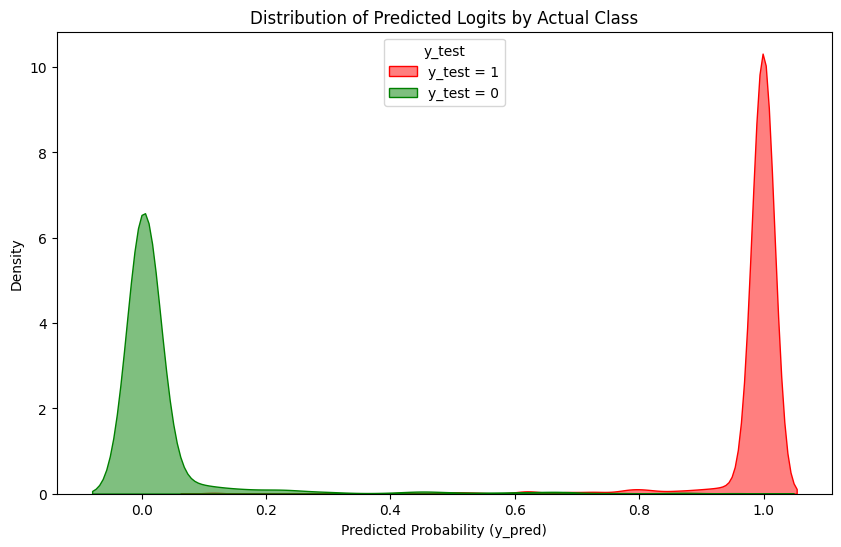

In [74]:
# Plot distribution of prediction logits
y_pred_logits = model3.predict(X_test)

# Create the plot using hue
df = pd.DataFrame({'y_pred': y_pred_logits.flatten(), 'y_test': y_test.flatten()})
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='y_pred', hue='y_test', fill=True, alpha=0.5, palette={0: 'green', 1: 'red'})

# Add labels and title
plt.xlabel("Predicted Probability (y_pred)")
plt.ylabel("Density")
plt.title("Distribution of Predicted Logits by Actual Class")
plt.legend(title="y_test", labels=["y_test = 1", "y_test = 0"],loc='upper center')
plt.show()

<b>Observations:</b>


* Most results are distributed around 0 and 1.
* There are some outliers of positives below 0.5.
* I'll set the Decision Threshold to 0.3 and observe the confusion matrix.

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1300
           1       0.97      1.00      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



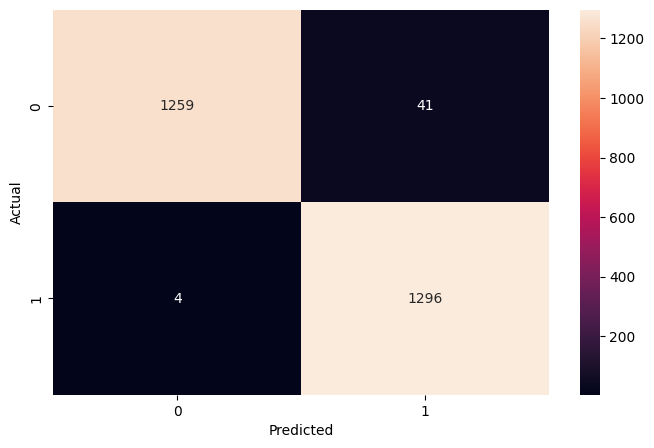

In [75]:
# Print classification report using new threshold

decision_threshold = 0.3
y_pred = (y_pred_logits >= decision_threshold).astype(int) # Convert logits to binary

# Print test classification report and
print_report(y_test, y_pred)

####<b> Observations and Conclusions from changing Decision Threshold:</b>

* Lowering Decision Threshold in Model-3 from 0.5 to 0.3 decreased the False Negatives from 8 to 4. This is an improvement of True Positive (true detection) from 99.3% to 99.7%.




#<b>Problem and Solution Summary</b>
####**The Problem:**</br>
Malaria is a lethal disease. Early and accurate diagnosis is crucial for effective treatment and reducing mortality rates. Automating malaria detection using deep learning can enhance diagnostic accuracy, reduce workload for medical professionals, and improve accessibility in resource-limited settings.


####**The Goal:** </br>
Develop a CNN-based AI model that can accurately classify blood cell images as either parasitized or uninfected.


####**The Proposed Solution:**<br>

* The proposed model is a Convolution Neural Network:
  - 4 Convolution blocks (#filters = 32, 64, 128, 128) with maxpool
  - 3 Dense layers (sizes 256, 128, 64)
  - 1 binary output (sigmoid activation function)
  - LeakyRelu activation on all other layers
* The above architecture gave better results than a smaller model
* Adding more neurons in the classification dense layers didn't improve the results (and it takes more resources)
* The model is trained on RGB dataset using data augmentation (horizontal flip, rotation, zoom in/out) which improves the training stability and test results by generalizing the data
* BatchNormalization did not improve the test results, so it's not included in my proposed model
* To minimize False Negatives which is more critical in malaria detection than False Positives, I used a decision-threshold of 0.3 for conversion from the sigmoid output logit to binary y_pred



#<b>Recommendation for Implementation</b></br>
####**Key Recommendations**:
* Implement the proposed model, including training with augmentation
* Ensure uniform image quality across different data sources to maintain model accuracy
* Conduct pilot studies to evaluate real-world performance.
* Compare model performance against human experts to ensure reliability
* Embed the model into hospital systems, or diagnostic devices for adoption by healthcare professionals

####**Key Actionables for Stakeholders**:
* Implement the AI tool in diagnostic workflows, train staff, and provide feedback for continuous improvement
* Facilitate AI adoption in resource-limited settings where malaria is prevalent
* Data collection - Standardize image acquisition protocols to reduce variability. Continuously update the dataset with new cases to improve model robustness
* Conduct pilot studies in real-world settings before deployment

####**Expected Benefit and/or Costs**:
* Improved diagnosis speed and accuracy, reduce human error
* Cost saving - reduce the need for expert pathologists and cutting operational costs
* Costs to consider:
  - Data collection and preparation
  - Infrastructure & Deployment (cloud)
  - Maintenance and model refinement
  - Training

####**Potential Risks**:
* Data Bias - The model may perform differently on images from different sources or populations
* Trust issues against AI-based diagnoses
* Getting approval from regulatory agencies

####**Further Analysis**:
* Ensure high-quality, error-free well-labeled images for training
* Continuously update the dataset with new cases to improve model robustness
* Perform testing with cross-validation to prevent overfitting
* Compare model performance against human experts to ensure reliability
* Optimize the model by optimizing hyper-parameters (training parameters, augmentation ranges, dropout values)
* Evaluate other techniques to minimize False-Negatives (optimize training with weighted-class to prioritize False-Negative)

  